# Elementwise Average Fusion model testing (OverSampler, cosine scheduling, BCE loss):

In [6]:
import sys
root = '../../'
sys.path.append(root)   # Done to be able to import the packages and functions

import Utils.hico_evaluation.evaluation as ev
from Utils.custom_sampler import OverSampler
from Utils.custom_loss import MaskedBCELoss
from Utils.annotation_preprocessing import _load_csv_to_tensor
from Utils.train_val_split import train_val_split_hico
from hoi_classifiers import ElementwiseAvgFusionModel

import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

import random

In [7]:
seed = 42   #note that the model parameters will still be randomly initiated
torch.manual_seed(seed)
random.seed(seed)

### Loading the training set:


In [8]:
# Loading the data:
X_train = torch.load(root + "Embeddings/Combined_Embeddings/train.pt")[:,(0,2),:]
y_train = _load_csv_to_tensor(root + "anno/added/anno_augmented_train.csv").T # Transpose to make both first dimensions the #samples.
y_train[y_train.isnan()] = -1

### Loading the test set:

In [9]:
X_test = torch.load(root + "Embeddings/Combined_Embeddings/test.pt")[:,(0,2),:]
y_test = _load_csv_to_tensor(root + "anno/added/anno_augmented_test.csv").T # Transpose to make both first dimensions the #samples.
y_test[y_test.isnan()] = -1

#### Training Preparations:

In [10]:
train_dataset = TensorDataset(X_train, y_train)

In [11]:
# Batch size:
bs = 512

sampler = OverSampler(y_train[:,:600], shuffle=True)

train_dataloader = DataLoader(
    train_dataset, batch_size=bs, num_workers=4, sampler=sampler)


In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
model = ElementwiseAvgFusionModel(512,655,797)
model = model.to(device)

In [14]:
classweights = torch.cat((torch.ones(600),torch.ones(197)*0.5)).to(device)      # The hoi classes weigh twice as much as the seperate classes
criterion = MaskedBCELoss(ignore_label=0, convert_target_to_01= True, weight=classweights)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)

c:\Users\rfigg\.conda\envs\PyTorch\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


#### Training loop:

In [15]:
num_epochs = 101
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        running_loss += loss.item()

    scheduler.step()
    

    print(f"Epoch {epoch+1:0{len(str(num_epochs))}}/{num_epochs}, Loss: {running_loss/len(train_dataloader):.12f}")

Epoch 001/101, Loss: 0.102161373800
Epoch 002/101, Loss: 0.019155264351
Epoch 003/101, Loss: 0.015394335377
Epoch 004/101, Loss: 0.013633692709
Epoch 005/101, Loss: 0.013009846671
Epoch 006/101, Loss: 0.011822240908
Epoch 007/101, Loss: 0.010198219679
Epoch 008/101, Loss: 0.009262886645
Epoch 009/101, Loss: 0.008790812486
Epoch 010/101, Loss: 0.008605511736
Epoch 011/101, Loss: 0.008292114981
Epoch 012/101, Loss: 0.007765960138
Epoch 013/101, Loss: 0.007403560740
Epoch 014/101, Loss: 0.007186533013
Epoch 015/101, Loss: 0.007072834876
Epoch 016/101, Loss: 0.006958642586
Epoch 017/101, Loss: 0.006673778852
Epoch 018/101, Loss: 0.006457940537
Epoch 019/101, Loss: 0.006323063864
Epoch 020/101, Loss: 0.006270897651
Epoch 021/101, Loss: 0.006214919387
Epoch 022/101, Loss: 0.006036165247
Epoch 023/101, Loss: 0.005904202303
Epoch 024/101, Loss: 0.005797527510
Epoch 025/101, Loss: 0.005741106423
Epoch 026/101, Loss: 0.005726626547
Epoch 027/101, Loss: 0.005600386627
Epoch 028/101, Loss: 0.00548

#### Evaluating model:

In [16]:
test_pred = model.forward(X_test.to(device))
test_map = ev.eval_vo(test_pred[:,:600].T.cpu().detach().numpy(), y_test[:,:600].T.numpy(),600)[0].mean()

In [17]:
print(test_map * 100)

53.26899638839805


In [18]:
one_shot_list = torch.where((0 < (y_train[:,:600] == 1).sum(dim=0)) & ((y_train[:,:600] == 1).sum(dim=0) <= 1))[0]
few_shot_list_5 = torch.where((0 < (y_train[:,:600] == 1).sum(dim=0)) & ((y_train[:,:600] == 1).sum(dim=0) <= 5))[0]
few_shot_list_10 = torch.where((0 < (y_train[:,:600] == 1).sum(dim=0)) & ((y_train[:,:600] == 1).sum(dim=0) <= 10))[0]

one_shot_map = ev.eval_vo(test_pred[:,one_shot_list].T.cpu().detach().numpy(), y_test[:,one_shot_list].T.numpy(),len(one_shot_list))[0].mean()
few_5_shot_map = ev.eval_vo(test_pred[:,few_shot_list_5].T.cpu().detach().numpy(), y_test[:,few_shot_list_5].T.numpy(),len(few_shot_list_5))[0].mean()
few_10_shot_map = ev.eval_vo(test_pred[:,few_shot_list_10].T.cpu().detach().numpy(), y_test[:,few_shot_list_10].T.numpy(),len(few_shot_list_10))[0].mean()

print("Few@1 mAP: ", one_shot_map * 100)
print("Few@5 mAP: ", few_5_shot_map * 100)
print("Few@10 mAp: ", few_10_shot_map * 100)

Few@1 mAP:  30.86875377074948
Few@5 mAP:  37.59771387446993
Few@10 mAp:  38.61874330080315


[]

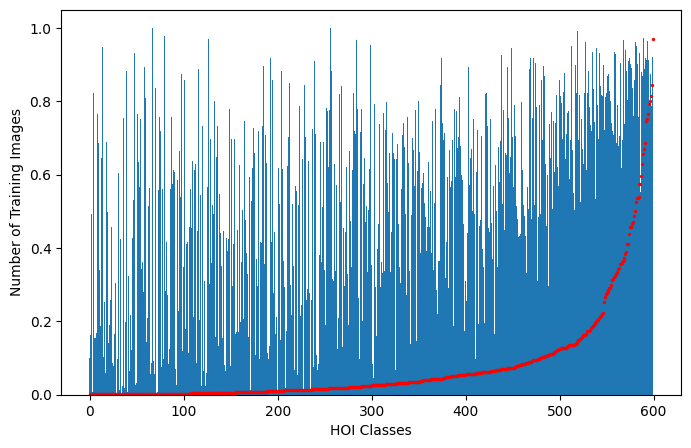

In [19]:
indices = torch.sum((y_train[:,:600] == 1).int(), dim = 0).sort().indices
test_aps = ev.eval_vo(test_pred[:,:600].T.cpu().detach().numpy(), y_test[:,:600].T.numpy(),600)[0]

plt.figure(figsize=(8,5))
plt.bar(range(600),test_aps[indices],width=1)
plt.scatter(range(600),torch.sum(y_train == 1, dim = 0)[indices] / 1500,s = 2,color = "red")
plt.xlabel('HOI Classes')
plt.ylabel('Number of Training Images')
plt.plot()